## Librerias

In [1]:
import pandas as pd
import urllib.request
from PIL import Image
import ML_ToolBox as tb
from sklearn.model_selection import train_test_split,  GridSearchCV
import bootcampviztools as vt
from sklearn.metrics import classification_report, make_scorer, precision_score, ConfusionMatrixDisplay,mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor
import bootcampviztools as bt
import matplotlib.pyplot as plt


## Data

In [2]:
### Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("data/train.csv", index_col = 0)
df.index.name = None

## Data exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


## Data processing

El target es la columna `Price_in_euros`

In [5]:
tb.describe_df(df)

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
Data_Type,object,object,object,float64,object,object,object,object,object,object,object,float64
Missings(%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unique_Values,19,480,6,17,36,107,9,37,93,9,165,603
Card(%),2.08,52.63,0.66,1.86,3.95,11.73,0.99,4.06,10.2,0.99,18.09,66.12


In [6]:
df["ram_GB"] = df["Ram"].str.replace("GB", "").astype(int)
df["weight_kg"] = df["Weight"].str.replace("kg", "").astype(float)



In [7]:
memory_split = df['Memory'].str.extract(r'(\d+)\s*([A-Za-z]+)\s*([A-Za-z]+)')
df['memory_type'] = memory_split[2]
df['capacity_gb'] = memory_split[0].astype(int)


In [8]:
df['capacity_gb'] = df.apply(lambda row: row['capacity_gb'] * 1000 if row['capacity_gb'] < 5 else row['capacity_gb'], axis=1)


In [9]:
cpu_split = df['Cpu'].str.extract(r'(Intel|AMD).*?(\d+(\.\d+)?GHz)')

df['cpu_brand'] = cpu_split[0]
df['cpu_speed'] = cpu_split[1].str.replace("GHz","").astype(float)


In [10]:
resolution_split = df['ScreenResolution'].str.extract(r'(?P<panel_type>.+?)\s*(?P<resolution>\d+x\d+)')
df['panel_type'] = resolution_split['panel_type']
df['resolution'] = resolution_split['resolution']
df.loc[df['panel_type'] == '1', 'panel_type'] = 'SD'

In [11]:
df.panel_type.value_counts()

panel_type
Full HD                                349
SD                                     231
IPS Panel Full HD                      167
IPS Panel Full HD / Touchscreen         32
Full HD / Touchscreen                   30
Touchscreen                             24
IPS Panel Retina Display                12
Quad HD+ / Touchscreen                  11
IPS Panel 4K Ultra HD / Touchscreen     10
IPS Panel Touchscreen                    8
4K Ultra HD / Touchscreen                7
IPS Panel                                7
IPS Panel Quad HD+ / Touchscreen         6
IPS Panel 4K Ultra HD                    5
IPS Panel Quad HD+                       4
4K Ultra HD                              3
Quad HD+                                 2
Touchscreen / Quad HD+                   1
2                                        1
Touchscreen / 4K Ultra HD                1
Touchscreen / Full HD                    1
Name: count, dtype: int64

In [12]:
fila_panel_type_2 = df.loc[df['panel_type'] == '2']
fila_panel_type_2.loc[fila_panel_type_2.index, 'resolution'] = '2560x1440'
fila_panel_type_2.loc[fila_panel_type_2.index, 'panel_type'] = 'Full HD'



In [13]:
df.drop(["ScreenResolution", "Cpu", "Memory", "Weight", "Ram"], axis= 1, inplace= True)

In [14]:
#Lo hago aqui porque al hacer el split me quedan diferentes compañias y se rompe todo
#ordinal_encoder = OrdinalEncoder()
#encoded_company_column = ordinal_encoder.fit_transform(df[['Company']])
#df['Company'] = encoded_company_column
#encoded_gpu_column = ordinal_encoder.fit_transform(df[['Gpu']])
#df['Gpu'] = encoded_gpu_column

In [15]:
#df.drop("Product", axis= 1, inplace = True)


In [16]:
df

,Company,Product,TypeName,Inches,Gpu,OpSys,Price_in_euros,ram_GB,weight_kg,memory_type,capacity_gb,cpu_brand,cpu_speed,panel_type,resolution
755,HP,250 G6,Notebook,15.6,Intel HD Graphics 520,Windows 10,539.00,8,1.86,SSD,256,Intel,2.0,Full HD,1920x1080
618,Dell,Inspiron 7559,Gaming,15.6,Nvidia GeForce GTX 960<U+039C>,Windows 10,879.01,16,2.59,HDD,1000,Intel,2.6,Full HD,1920x1080
909,HP,ProBook 450,Notebook,15.6,Nvidia GeForce 930MX,Windows 10,900.00,8,2.04,HDD,1000,Intel,2.7,Full HD,1920x1080
2,Apple,Macbook Air,Ultrabook,13.3,Intel HD Graphics 6000,macOS,898.94,8,1.34,Flash,128,Intel,1.8,SD,440x900
286,Dell,Inspiron 3567,Notebook,15.6,AMD Radeon R5 M430,Linux,428.00,4,2.25,HDD,1000,Intel,2.0,Full HD,1920x1080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Dell,Inspiron 5570,Notebook,15.6,AMD Radeon 530,Windows 10,800.00,8,2.20,SSD,256,Intel,1.6,Full HD,1920x1080
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Intel HD Graphics 520,Windows 10,1629.00,8,1.48,SSD,256,Intel,2.4,Full HD / Touchscreen,1920x1080
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Intel HD Graphics 620,No OS,519.00,8,2.20,HDD,2000,Intel,2.5,Full HD,1920x1080
23,HP,255 G6,Notebook,15.6,AMD Radeon R2,No OS,258.00,4,1.86,HDD,500,AMD,1.5,SD,366x768


-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [17]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(912, 14)

In [18]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [20]:
X_train.Company.value_counts()

Company
Lenovo       162
Dell         158
HP           155
Asus         101
Acer          55
Toshiba       31
MSI           30
Apple         13
Razer          4
Mediacom       4
Xiaomi         3
Microsoft      3
Samsung        3
Google         2
Fujitsu        2
Vero           2
Chuwi          1
Name: count, dtype: int64

In [21]:
X_test.Company.value_counts()

Company
Lenovo       40
HP           39
Dell         39
Asus         20
Acer         19
MSI           7
Apple         4
Toshiba       3
Samsung       2
Huawei        2
Microsoft     2
Razer         2
Mediacom      2
Chuwi         1
LG            1
Name: count, dtype: int64

In [22]:
features_num = df.select_dtypes(include=['int', 'float']).columns.to_list()
features_num.remove("Price_in_euros")
features_cat = df.select_dtypes(include= ["object"]).columns.to_list()


In [23]:
features_cat

['Company',
 'Product',
 'TypeName',
 'Gpu',
 'OpSys',
 'memory_type',
 'cpu_brand',
 'panel_type',
 'resolution']

array([[<Axes: title={'center': 'Inches'}>,
        <Axes: title={'center': 'ram_GB'}>],
       [<Axes: title={'center': 'weight_kg'}>,
        <Axes: title={'center': 'capacity_gb'}>],
       [<Axes: title={'center': 'cpu_speed'}>, <Axes: >]], dtype=object)

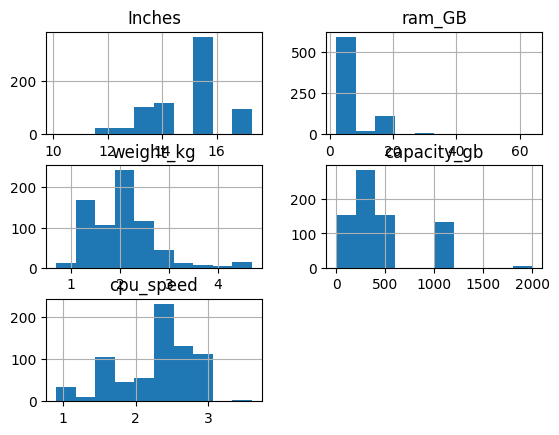

In [24]:
X_train[features_num].hist()

In [25]:
X_train_scal = X_train.copy()
X_test_scal = X_test.copy()

In [26]:
X_train_scal = pd.get_dummies(X_train_scal, columns= features_cat, dtype= int)
X_test_scal = pd.get_dummies(X_test_scal, columns= features_cat, dtype= int)

In [27]:
scaler = StandardScaler()
X_train_scal[features_num] = scaler.fit_transform(X_train_scal[features_num])
X_test_scal[features_num] = scaler.transform(X_test_scal[features_num])

In [28]:
#Hay features diferentres en train y test por el One Hot

In [29]:
columns_order = X_train_scal.columns
for column in columns_order:
    if column not in X_test_scal.columns:
        X_test[column] = 0
X_test_scal = X_test_scal.reindex(columns=columns_order)

C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\1257925788.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\1257925788.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_test[column] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\1257925788.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

In [30]:
X_test_scal.fillna(0, inplace= True)

In [31]:
X_train_scal.columns

Index(['Inches', 'ram_GB', 'weight_kg', 'capacity_gb', 'cpu_speed',
       'Company_Acer', 'Company_Apple', 'Company_Asus', 'Company_Chuwi',
       'Company_Dell',
       ...
       'resolution_2560x1440', 'resolution_2560x1600', 'resolution_2880x1800',
       'resolution_3200x1800', 'resolution_366x768', 'resolution_3840x2160',
       'resolution_440x900', 'resolution_560x1440', 'resolution_600x900',
       'resolution_920x1080'],
      dtype='object', length=572)

In [32]:
X_test_scal.columns

Index(['Inches', 'ram_GB', 'weight_kg', 'capacity_gb', 'cpu_speed',
       'Company_Acer', 'Company_Apple', 'Company_Asus', 'Company_Chuwi',
       'Company_Dell',
       ...
       'resolution_2560x1440', 'resolution_2560x1600', 'resolution_2880x1800',
       'resolution_3200x1800', 'resolution_366x768', 'resolution_3840x2160',
       'resolution_440x900', 'resolution_560x1440', 'resolution_600x900',
       'resolution_920x1080'],
      dtype='object', length=572)

In [33]:
X_test_scal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 451 to 260
Columns: 572 entries, Inches to resolution_920x1080
dtypes: float64(406), int32(166)
memory usage: 700.5 KB


### 3. Baseline de modelos


In [34]:
rf_reg = RandomForestRegressor(max_depth = 10, random_state= 42)
lin_reg = LinearRegression()
xgb_reg = XGBRegressor(max_depth = 10, random_state = 42)
cat_reg = CatBoostRegressor(iterations=150,
                          learning_rate=1,
                          depth=10)
modelos_reg = {
    "Random Forest": rf_reg,
    "Cat Boost": cat_reg,
    "Linear Regresion": lin_reg,
    #"XGBoost Regressor": xgb_reg
}

for tipo, modelo in modelos_reg.items():
    scores = cross_val_score(modelo, X_train_scal, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"{tipo}: {rmse_scores.mean()}")

Random Forest: 296.3752154185106
0:	learn: 371.6475542	total: 145ms	remaining: 21.6s
1:	learn: 332.5224571	total: 156ms	remaining: 11.5s
2:	learn: 285.2679357	total: 168ms	remaining: 8.25s
3:	learn: 262.3762120	total: 181ms	remaining: 6.61s
4:	learn: 229.6536518	total: 195ms	remaining: 5.65s
5:	learn: 225.2172730	total: 208ms	remaining: 4.98s
6:	learn: 211.2165126	total: 219ms	remaining: 4.48s
7:	learn: 199.0445965	total: 231ms	remaining: 4.1s
8:	learn: 192.0521412	total: 243ms	remaining: 3.8s
9:	learn: 175.4002919	total: 255ms	remaining: 3.57s
10:	learn: 170.9173995	total: 267ms	remaining: 3.37s
11:	learn: 165.8655800	total: 280ms	remaining: 3.22s
12:	learn: 162.7457407	total: 293ms	remaining: 3.09s
13:	learn: 153.2505734	total: 306ms	remaining: 2.97s
14:	learn: 142.9153910	total: 319ms	remaining: 2.87s
15:	learn: 140.1089158	total: 331ms	remaining: 2.77s
16:	learn: 135.2826052	total: 343ms	remaining: 2.68s
17:	learn: 132.9484932	total: 355ms	remaining: 2.6s
18:	learn: 129.0337811	tot

121:	learn: 21.1126403	total: 1.52s	remaining: 350ms
122:	learn: 21.0480187	total: 1.54s	remaining: 337ms
123:	learn: 20.6118785	total: 1.55s	remaining: 325ms
124:	learn: 20.5339406	total: 1.56s	remaining: 313ms
125:	learn: 20.2482898	total: 1.61s	remaining: 306ms
126:	learn: 20.1742468	total: 1.62s	remaining: 294ms
127:	learn: 20.1104037	total: 1.64s	remaining: 281ms
128:	learn: 19.5716607	total: 1.65s	remaining: 268ms
129:	learn: 19.5117671	total: 1.66s	remaining: 256ms
130:	learn: 19.4569617	total: 1.68s	remaining: 243ms
131:	learn: 19.3952008	total: 1.69s	remaining: 230ms
132:	learn: 19.3421266	total: 1.7s	remaining: 218ms
133:	learn: 19.2595418	total: 1.72s	remaining: 205ms
134:	learn: 19.0375209	total: 1.73s	remaining: 192ms
135:	learn: 18.6669103	total: 1.74s	remaining: 179ms
136:	learn: 18.6113129	total: 1.75s	remaining: 166ms
137:	learn: 18.3451262	total: 1.77s	remaining: 154ms
138:	learn: 18.2928629	total: 1.78s	remaining: 141ms
139:	learn: 17.9768283	total: 1.79s	remaining: 

In [35]:
param_grid_rf = {
    "n_estimators" : [10,25,50,60,100],
    "max_depth" : [None,30, 40, 45, 50],
    "min_samples_split": [1, 2, 3, 4],
    "min_samples_leaf" : [1, 2, 3, 4],
    "max_features" : ["log2", "sqrt", None]
}

best_model_rf = GridSearchCV(rf_reg, param_grid= param_grid_rf, cv = 5, scoring= "neg_mean_squared_error",n_jobs= -1)
best_model_rf.fit(X_train_scal, y_train)

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
1500 fits failed out of a total of 6000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1500 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\b

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=10, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 30, 40, 45, 50],
                         'max_features': ['log2', 'sqrt', None],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [1, 2, 3, 4],
                         'n_estimators': [10, 25, 50, 60, 100]},
             scoring='neg_mean_squared_error')

In [36]:
param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}
best_model_cat = GridSearchCV(estimator=cat_reg, param_grid=param_grid_cat, cv=5, scoring='neg_mean_squared_error')
best_model_cat.fit(X_train_scal, y_train)

0:	learn: 674.3181929	total: 1.27ms	remaining: 125ms
1:	learn: 670.7958244	total: 2.63ms	remaining: 129ms
2:	learn: 667.5010505	total: 3.67ms	remaining: 119ms
3:	learn: 663.8865150	total: 4.83ms	remaining: 116ms
4:	learn: 660.0406427	total: 5.9ms	remaining: 112ms
5:	learn: 656.5970768	total: 6.9ms	remaining: 108ms
6:	learn: 653.5274014	total: 7.93ms	remaining: 105ms
7:	learn: 649.9552412	total: 8.93ms	remaining: 103ms
8:	learn: 646.5935864	total: 9.96ms	remaining: 101ms
9:	learn: 643.2040973	total: 11ms	remaining: 99.3ms
10:	learn: 639.7822725	total: 12.1ms	remaining: 97.7ms
11:	learn: 636.4921407	total: 13.1ms	remaining: 96ms
12:	learn: 633.4438056	total: 14.1ms	remaining: 94.1ms
13:	learn: 630.2108769	total: 15.1ms	remaining: 92.7ms
14:	learn: 626.8322957	total: 16.1ms	remaining: 91.2ms
15:	learn: 623.9336670	total: 17.1ms	remaining: 89.7ms
16:	learn: 620.8714630	total: 18.2ms	remaining: 88.7ms
17:	learn: 617.9109461	total: 19.1ms	remaining: 87.2ms
18:	learn: 614.7859445	total: 20.2m

27:	learn: 584.1574980	total: 29.3ms	remaining: 75.4ms
28:	learn: 581.5627665	total: 30.4ms	remaining: 74.4ms
29:	learn: 578.9454867	total: 31.4ms	remaining: 73.3ms
30:	learn: 576.5505039	total: 32.4ms	remaining: 72.2ms
31:	learn: 574.0453692	total: 33.5ms	remaining: 71.2ms
32:	learn: 571.4055943	total: 34.6ms	remaining: 70.2ms
33:	learn: 568.8942681	total: 35.6ms	remaining: 69ms
34:	learn: 566.5316806	total: 36.6ms	remaining: 68ms
35:	learn: 564.0325515	total: 37.7ms	remaining: 67.1ms
36:	learn: 561.9827947	total: 38.9ms	remaining: 66.2ms
37:	learn: 559.9213520	total: 40ms	remaining: 65.2ms
38:	learn: 557.5611340	total: 41.1ms	remaining: 64.2ms
39:	learn: 555.0105934	total: 42.1ms	remaining: 63.2ms
40:	learn: 553.2966233	total: 43.1ms	remaining: 62.1ms
41:	learn: 550.9362380	total: 44.2ms	remaining: 61ms
42:	learn: 548.6176140	total: 45.2ms	remaining: 59.9ms
43:	learn: 546.5110152	total: 46.2ms	remaining: 58.8ms
44:	learn: 544.2854329	total: 47.3ms	remaining: 57.8ms
45:	learn: 542.005

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x000002206B37C880>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_squared_error')

In [37]:
print(best_model_rf.best_params_)
print(np.sqrt(-best_model_rf.best_score_))
print(best_model_cat.best_params_)
print(np.sqrt(-best_model_cat.best_score_))

{'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
289.1944624893168
{'depth': 6, 'iterations': 300, 'learning_rate': 0.1}
267.0439003812169


In [38]:
best_model = best_model_cat

In [39]:
#metrica = RMSE
# Probar con todos,
# Cross validation
# quedarme con los mejores
# Grid Search
# optimización



In [40]:
y_pred = best_model.best_estimator_.predict(X_test_scal)
print("RMSE", np.sqrt(mean_squared_error(y_test, y_pred)))

RMSE 293.0492737859379


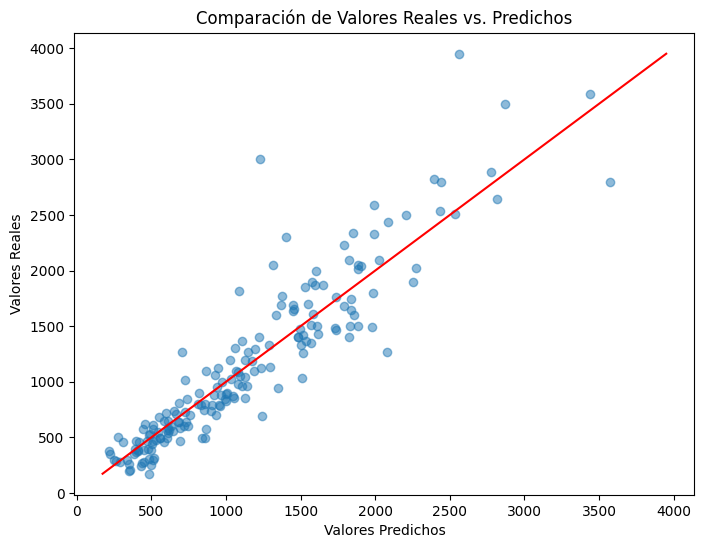

In [41]:
def plot_predictions_vs_actual(y_real, y_pred):
    """
    Función para graficar los valores reales vs. los valores predichos en una regresión.

    Args:
    y_real (array-like): Valores reales de la variable objetivo.
    y_pred (array-like): Valores predichos de la variable objetivo.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, y_real, alpha=0.5)
    plt.xlabel("Valores Predichos")
    plt.ylabel("Valores Reales")

    # Línea y=x
    max_value = max(max(y_real), max(y_pred))
    min_value = min(min(y_real), min(y_pred))
    plt.plot([min_value, max_value], [min_value, max_value], 'r')

    plt.title("Comparación de Valores Reales vs. Predichos")
    plt.show()
plot_predictions_vs_actual(y_test, y_pred)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de RMSE.

In [42]:
#from sklearn.metrics import mean_squared_error (mse)
y_predict = best_model.predict(X_test_scal)
mse = mean_squared_error(y_test, y_predict) 
RMSE = np.sqrt(mse)
print(RMSE)

293.0492737859379


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [43]:
X_pred = pd.read_csv("data/test.csv", index_col= 0)
X_pred.index.name = None 
X_pred.head()

# Hacer las mismas transformaciones que en el df de train

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [44]:
#Transformaciones:
X_pred["ram_GB"] = X_pred["Ram"].str.replace("GB", "").astype(int)
X_pred["weight_kg"] = X_pred["Weight"].str.replace("kg", "").astype(float)

memory_split = X_pred['Memory'].str.extract(r'(\d+)\s*([A-Za-z]+)\s*([A-Za-z]+)')
X_pred['memory_type'] = memory_split[2]
X_pred['capacity_gb'] = memory_split[0].astype(int)
X_pred['capacity_gb'] = X_pred.apply(lambda row: row['capacity_gb'] * 1000 if row['capacity_gb'] < 5 else row['capacity_gb'], axis=1)

cpu_split = X_pred['Cpu'].str.extract(r'(Intel|AMD).*?(\d+(\.\d+)?GHz)')
X_pred['cpu_brand'] = cpu_split[0]
X_pred['cpu_speed'] = cpu_split[1].str.replace("GHz","").astype(float)

resolution_split = X_pred['ScreenResolution'].str.extract(r'(?P<panel_type>.+?)\s*(?P<resolution>\d+x\d+)')
X_pred['panel_type'] = resolution_split['panel_type']
X_pred['resolution'] = resolution_split['resolution']
X_pred.loc[X_pred['panel_type'] == '1', 'panel_type'] = 'SD'
fila_panel_type_2 = X_pred.loc[X_pred['panel_type'] == '2']
fila_panel_type_2.loc[fila_panel_type_2.index, 'resolution'] = '2560x1440'
fila_panel_type_2.loc[fila_panel_type_2.index, 'panel_type'] = 'Full HD'

X_pred.drop(["ScreenResolution", "Cpu", "Memory", "Weight", "Ram"], axis= 1, inplace= True)

features_num = X_pred.select_dtypes(include=['int', 'float']).columns.to_list()

features_cat = X_pred.select_dtypes(include= ["object"]).columns.to_list()

X_pred = pd.get_dummies(X_pred, columns= features_cat, dtype= int)

scaler = StandardScaler()

X_pred[features_num] = scaler.fit_transform(X_pred[features_num])

columns_order = X_train_scal.columns
for column in columns_order:
    if column not in X_pred.columns:
        X_pred[column] = 0
        
X_pred = X_pred.reindex(columns=columns_order)
X_test_scal.fillna(0, inplace= True)


X_pred.head()

C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\251287955.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_pred[column] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\251287955.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_pred[column] = 0
C:\Users\lucas\AppData\Local\Temp\ipykernel_27700\251287955.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axi

,Inches,ram_GB,weight_kg,capacity_gb,cpu_speed,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,...,resolution_2560x1440,resolution_2560x1600,resolution_2880x1800,resolution_3200x1800,resolution_366x768,resolution_3840x2160,resolution_440x900,resolution_560x1440,resolution_600x900,resolution_920x1080
209,0.357415,1.420931,0.502123,0.140767,0.978917,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1281,0.357415,-0.902069,0.502123,0.108915,-1.512561,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1168,0.357415,-0.902069,-0.250117,1.436076,-0.682069,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1231,0.357415,-0.127735,0.187687,-0.538739,0.356047,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1020,-0.786899,-0.902069,-0.174893,-0.538739,0.356047,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X_pred.shape

(391, 572)

In [46]:
predictions_submit = best_model.predict(X_pred)
predictions_submit

array([1607.54715231,  319.0630401 ,  324.93741036, 1044.88623515,
        820.07846254,  376.4245568 ,  792.57133694, 1005.87935816,
       1414.48881463,  306.15882493, 2148.84508781, 1334.69422499,
        531.84237816, 1707.161006  ,  925.34978761,  677.03905269,
       2377.95329949, 1475.96522468, 1904.85120534,  669.33167433,
       1422.48263265,  424.76125289,  767.46575733, 1298.0086622 ,
        596.46247373,  668.96249217,  668.64568091,  647.87080119,
       2641.08450325, 1091.90143552, 2480.48485384,  390.79874324,
        821.14656615, 3072.99536023, 2022.56666024, 1663.93676792,
        545.40917514, 1248.02633676,  841.36962372, 1784.68713323,
        758.67257855,  996.17899447,  565.26610648, 1245.81124714,
       1120.2459067 , 1008.98831703, 1091.79034808,  629.00330016,
        793.01926916,  491.39194359, 1666.72698698,  666.43768684,
       1132.99429762,  390.56682292, 1867.81962246, 1716.55881825,
        750.03652483,  770.89709208,  913.14927131,  647.11987

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [47]:
# ¿Qué opináis?
# ¿Sí, no?

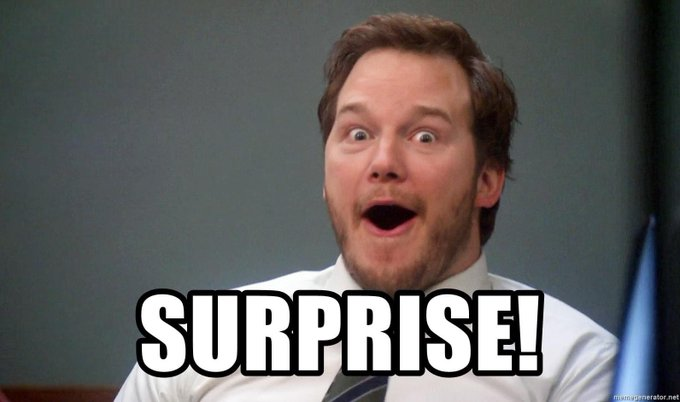

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [48]:
sample = pd.read_csv("data/sample_submission.csv")

In [49]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [50]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [51]:
submission = pd.DataFrame({"laptop_ID": X_pred.index, "Price_in_euros": predictions_submit})

In [52]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1607.547152
1,1281,319.063040
2,1168,324.937410
3,1231,1044.886235
4,1020,820.078463


In [53]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [54]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Iván y Manuel: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `laptops_test.csv`. Lloramos.")

In [55]:
chequeador(submission)

You're ready to submit!
